**<center> Joaquin Peñuela Parra, Cristian Fernando Rodriguez Cruz <center>**
**<center> University of Los Andes <center>**
**<center> High Energy Physics Group: Phenomenology of Particles <center>**

This code was written to be running in Docker. If you do not have a Docker inside hep-server2 please refer to: https://github.com/Phenomenology-group-uniandes/Tutoriales_Generales

In [1]:
import os
import sys
import numpy as np
import pandas as pd

!git clone https://github.com/Phenomenology-group-uniandes/Heatmap_Utilities.git
import nbimporter
sys.path.append(f'{os.getcwd()}/Heatmap_Utilities')
from Heatmap_Utilities.Main_Functions import smooth, plot_heatmap

Cloning into 'Heatmap_Utilities'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 58 (delta 25), reused 32 (delta 11), pack-reused 0
Receiving objects: 100% (58/58), 2.68 MiB | 4.29 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [2]:
def approx_global_sig(sig: np.array, bkg: np.array, N: float = 0.0) -> float:
    """
    Calculates the statistical significance of a signal over background in a given dataset using a modified version of
    the formula (S -N sqrt(B))/sqrt(S+B), where S is the number of signal events, B is the number of background events,
    and N is the expected number of background events in the signal region.

    Parameters:
    sig (np.array): 1D array containing the number of signal events in each bin of the dataset.
    bkg (np.array): 1D array containing the number of background events in each bin of the dataset.
    N (float): Expected number of background events in the signal region. Default value is 0.0.

    Returns:
    float: The statistical significance of the signal over background in the dataset.
    """

    # calculate weight factor w for each bin
    w = np.log(1. + sig/(bkg + 1e-9))

    # calculate intermediate quantities
    s_w = sig * w
    b_w = bkg * w
    s_ww = sig * w ** 2
    b_ww = bkg * w ** 2

    # calculate numerator and denominator of modified formula
    num = np.sum(s_w) - N * np.sqrt(np.sum(b_ww))
    den = np.sqrt(np.sum(s_ww + b_ww))

    # calculate statistical significance and return it
    return num / den

In [3]:
channels = ["hadronic_dLQ", "hadronic_sLQ", "hadronic_non-resonant", "semileptonic_dLQ", "semileptonic_sLQ", "semileptonic_non-resonant"]
Masses = [
    "1000",
    '1250', 
    '1500', 
    '1750', 
    '2000', 
    '2250', 
    '2500'
]

signals = ['Lq_Lq', 'tau_Lq', 'tau_tau']
bkgs =  ['tbart', 'V+jets', 'stop', 'Diboson']

In [4]:
Significances = {}

for signal in signals:
    
    KFactors_Matrix = pd.read_excel(f'KFactors_by_coupling/{signal}.xlsx', index_col= 0)
    KFactors_Matrix.columns = [float(column) for column in KFactors_Matrix.columns]
    KFactors_Matrix.index = [float(idx) for idx in KFactors_Matrix.index]
    
    Significances[signal] = {}
    for Mass in Masses:
        
        Significances[signal][float(Mass)] = {} 

        Matrix_Signal = np.zeros([49,6])
        Matrix_BKG = np.zeros([49,6])
        
        for n, channel in enumerate(channels):
            path_to_txt = os.path.join('Histograms',channel, f'M{Mass}', f"high_per_bin_{signal}.txt")
            Matrix_Signal[:, n] =  np.loadtxt(path_to_txt)
            
            for bkg in bkgs:
                path_to_txt = os.path.join('Histograms',channel, f'M{Mass}', f"high_per_bin_{bkg}.txt")
                Matrix_BKG[:, n] += np.loadtxt(path_to_txt)                
        
        for coupling in KFactors_Matrix.index:
            Signal_Data = np.asarray(Matrix_Signal.reshape((1,49*6)))*KFactors_Matrix[float(Mass)][coupling]
            BKG_Data = np.asarray(Matrix_BKG.reshape((1,49*6)))

            Significance_1_8 = approx_global_sig(Signal_Data, BKG_Data)
            Significances[signal][float(Mass)][coupling] = Significance_1_8

In [5]:
#Combined:

KFactors_Matrix_lq_lq = pd.read_excel(f'KFactors_by_coupling/Lq_Lq.xlsx', index_col= 0)
KFactors_Matrix_tau_lq = pd.read_excel(f'KFactors_by_coupling/tau_Lq.xlsx', index_col= 0)
KFactors_Matrix_tau_tau = pd.read_excel(f'KFactors_by_coupling/tau_tau.xlsx', index_col= 0)

KFactors_Matrix = {
    "Lq_Lq" : KFactors_Matrix_lq_lq,
    "tau_Lq" : KFactors_Matrix_tau_lq,
    "tau_tau" : KFactors_Matrix_tau_tau
}



Significances['Combined'] = {}
for Mass in Masses:

    Significances['Combined'][float(Mass)] = {} 

    Matrix_Signal = np.zeros([49,6])
    Matrix_BKG = np.zeros([49,6])
    for coupling in KFactors_Matrix["Lq_Lq"].index:
        for n, channel in enumerate(channels):
            for signal in signals:            
                path_to_txt = os.path.join('Histograms',channel, f'M{Mass}', f"high_per_bin_{signal}.txt")
                Matrix_Signal[:, n] +=  np.loadtxt(path_to_txt)*KFactors_Matrix[signal][int(Mass)][coupling]

            for bkg in bkgs:
                path_to_txt = os.path.join('Histograms',channel, f'M{Mass}', f"high_per_bin_{bkg}.txt")
                Matrix_BKG[:, n] += np.loadtxt(path_to_txt)                


        Signal_Data = np.asarray(Matrix_Signal.reshape((1,49*6)))
        BKG_Data = np.asarray(Matrix_BKG.reshape((1,49*6)))    
        Significances['Combined'][float(Mass)][coupling] = approx_global_sig(Signal_Data, BKG_Data)

In [6]:
KFactors_Matrix["tau_Lq"].columns

Int64Index([1000, 1250, 1500, 1750, 2000, 2250, 2500], dtype='int64')

In [7]:
pd.DataFrame.from_dict(Significances['Lq_Lq']) 

,1000.0,1250.0,1500.0,1750.0,2000.0,2250.0,2500.0
0.25,45.372622,14.068310,3.353039,0.971170,0.194617,0.053731,0.013424
0.50,45.479817,14.068310,3.365198,0.972495,0.194617,0.054001,0.013560
1.00,45.403266,14.061700,3.351093,0.971833,0.195206,0.053462,0.013628
1.50,45.510415,14.094739,3.370060,0.970507,0.194617,0.054135,0.013560
1.80,45.245308,14.160159,3.372014,0.976742,0.196337,0.054221,0.013612
2.00,46.134787,14.249586,3.406985,0.987069,0.197563,0.054337,0.013628
2.50,47.128600,14.628730,3.508778,1.008243,0.202276,0.055415,0.013832
3.00,49.018213,15.224775,3.689688,1.059078,0.211111,0.057367,0.014309
3.50,52.172496,16.291127,3.971165,1.140599,0.225240,0.060868,0.014990


In [8]:
Significances['Lq_Lq'][1250.0][0.25]

14.068310289457964

In [9]:
Significances.keys()

dict_keys(['Lq_Lq', 'tau_Lq', 'tau_tau', 'Combined'])

In [10]:
for key in Significances:
    pd.DataFrame.from_dict(Significances[key]).to_csv(f'Tables_and_Heatmaps/{key}.csv')

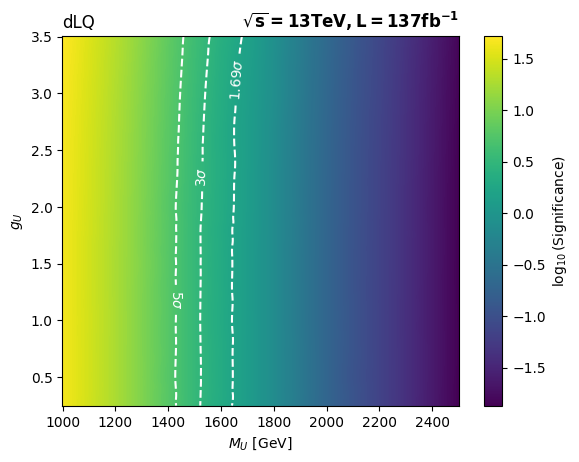

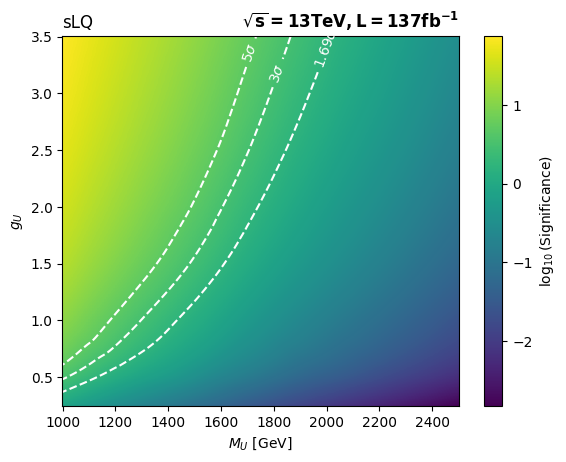

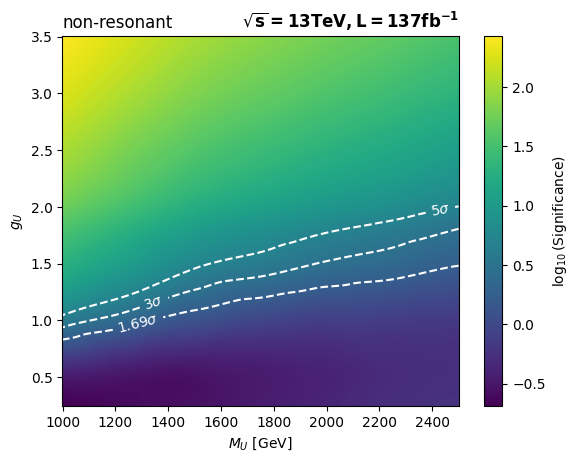

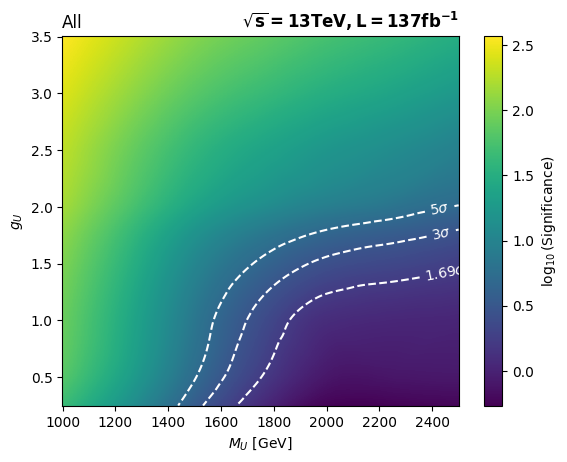

In [11]:
titulos_izquierda = {'Combined' : 'All', 'Lq_Lq' : 'dLQ', 'tau_Lq' : 'sLQ', 'tau_tau' : 'non-resonant'}

for key in Significances:
    Data = pd.DataFrame.from_dict(Significances[key])
    Data_interpolate = smooth(Data, log = True)
    plot_heatmap(Data_interpolate,
                 curvas_de_nivel = {np.log10(1.69) : r'$1.69 \sigma$', np.log10(3): r'$3 \sigma$', np.log10(5): r'$5 \sigma$'},
                 titulos = {'titulo':'','titulo_izquierda': titulos_izquierda[key],'titulo_derecha': r'$\mathbf{\sqrt{s} = 13 TeV, L = 137 fb^{-1}}$' ,'x_label': r'$M_{U}$ [GeV]', 'y_label': r'$g_U$', 'cbar_label': r'$\log_{10}$(Significance)'},
                 PDF_name = f'Tables_and_Heatmaps/{key}.png')

In [12]:
!rm -rf Heatmap_Utilities/